In [11]:
import os
import time
import glob
import dit
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns;sns.set()
import pandas as pd
from scipy.optimize import minimize

os.chdir("../")
from jointpdfpython3.measures import synergistic_entropy_upper_bound
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")

## Load all relent data & plot

4 0.9 Original data lenght: 10
New data length 10
4 0.4 Original data lenght: 10
New data length 10
4 0.6 Original data lenght: 10
New data length 10
4 0.8 Original data lenght: 11
New data length 10
2 0.9 Original data lenght: 11
New data length 10
2 0.4 Original data lenght: 10
New data length 10
2 0.6 Original data lenght: 10
New data length 10
2 0.8 Original data lenght: 11
New data length 10
3 0.9 Original data lenght: 11
New data length 10
3 0.4 Original data lenght: 10
New data length 10
3 0.6 Original data lenght: 10
New data length 10
3 0.8 Original data lenght: 11
New data length 10


Text(0.5, 0, 'relative entropy level')

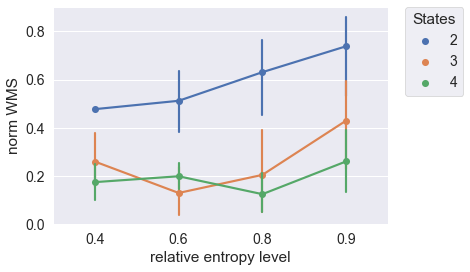

In [14]:
d = pd.read_pickle("../../results/rq12/allsamelevel.pkl")
ds = []
for i in d['states'].unique():
    for j in d['relent'].unique():
        ds.append(d[(d['states']==i)&(d['relent']==j)].head(10))
        print(i,j,"Original data lenght:",len(d[(d['states']==i)&(d['relent']==j)]))
        print("New data length",len(ds[-1]))

d=pd.concat(ds)

sns.set_context("paper", font_scale = 1.6, rc={"grid.linewidth": 1})
lineplot = sns.pointplot(data=d,x='relent',y='syndisc_normsyn',hue='states')
fig = lineplot.get_figure()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.01,title='States')
plt.ylabel("norm WMS")
plt.xlabel("relative entropy level")

## Scipy optimize to find distribution with exact H(X1),H(X2),I(X1;X2) values

In [4]:
def costparams(srvparams,jXS,maxent,relent,relmi):
    params2matrix_incremental(jXS,srvparams)
    mi = jXS.mutual_information([0],[1])
    ent1 = jXS.entropy([0])
    ent2 = jXS.entropy([1])
    minmi = min(ent1,ent2)
    return (abs(relent-(ent1/maxent))/relent)+(abs(relent-(ent2/maxent))/relent)+(abs(relmi-(mi/minmi))/relmi)

In [10]:
sts = [2]
lenX = 2
relents = [0.9]
minimize_options = {'ftol': 1e-6}
samples=2
relmi = None
for s in sts:
    for j,relent in enumerate(relents):
        jX = JointProbabilityMatrix(lenX,s,joint_probs='iid')
        lenpars = len(matrix2params_incremental(jX))
        maxent = jX.entropy([0])
        minmi = 1
        relmi=relent
        for i in range(samples):
            data = {'states':[],'parX':[],'relent':[],'maxent':[],'relmi':[],'mi':[]}
            ent1=0
            ent2=0
            mi=0
            maxmi=1
            try:
                while (abs(relent-(ent1/maxent))/relent)+(abs(relent-(ent2/maxent))/relent)+(abs(relmi-(mi/minmi))/relmi)>0.05:
                    opts = []
                    costs = []
                    for tries in range(75):
                        if tries % 25 == 0:
                            print(tries,datetime.fromtimestamp(time.time()))
                        parX = np.random.random(lenpars)
                        optres_ix = minimize(costparams,
                                                    parX,
                                                    bounds=[(0.0, 1.0)]*len(parX),
                                                    args=(jX,maxent,relent,relmi),
                                                    options=minimize_options)
                        opts.append(optres_ix.x)
                        costs.append(optres_ix.fun)
                    opt = opts[costs.index(min(costs))]
                    params2matrix_incremental(jX,opt)
                    mi = jX.mutual_information([0],[1])
                    ent1 = jX.entropy([0])
                    ent2 = jX.entropy([1])
                    minmi=min(ent1,ent2)
                print(i,ent1,ent2,mi)
                data['states'].append(s)
                data['parX'].append(opt)
                data['relent'].append(relent)
                data['maxent'].append(maxent)
                data['relmi'].append(relmi)
                data['mi'].append(mi)
                df = pd.DataFrame(data=data)
                df.to_pickle("../../results/test/scipyparxstates"+str(s)+"-"+str(j)+"-"+str(i)+".pkl")
            except:
                opt = None
                print("ERROR")

3.0
0 2022-06-02 14:00:51.473131
25 2022-06-02 14:00:52.340845
50 2022-06-02 14:00:54.436202
0 2022-06-02 14:00:57.980718
25 2022-06-02 14:00:59.048860
50 2022-06-02 14:01:01.724701
0 2022-06-02 14:01:04.117299
25 2022-06-02 14:01:06.517879
50 2022-06-02 14:01:08.170455
0 2022-06-02 14:01:08.902822
25 2022-06-02 14:01:11.324308
50 2022-06-02 14:01:13.708927
0 2022-06-02 14:01:16.925361
25 2022-06-02 14:01:20.885726
50 2022-06-02 14:01:23.182577
0 2022-06-02 14:01:24.145040
25 2022-06-02 14:01:26.549572
50 2022-06-02 14:01:27.618711
0 2022-06-02 14:01:31.935196
25 2022-06-02 14:01:33.363376
50 2022-06-02 14:01:35.216417
0 2022-06-02 14:01:36.305505
25 2022-06-02 14:01:38.410836
50 2022-06-02 14:01:41.957040
0 2022-06-02 14:01:49.202652
25 2022-06-02 14:01:51.017797
50 2022-06-02 14:01:52.830945
0 2022-06-02 14:01:56.205915
25 2022-06-02 14:01:58.477837
50 2022-06-02 14:02:03.072544
0 2022-06-02 14:02:05.089150
25 2022-06-02 14:02:07.515692
50 2022-06-02 14:02:09.480399
0 2022-06-02 14:0

## Concat and Save single found specific systems 

In [16]:
dist_type = 'scipyparx'
ds = []
folder = '../../results/test/'
os.chdir(folder)
allfiles = glob.glob("*.pkl")
files = [file for file in allfiles if dist_type in file]
if len(files) != 0:
    cur = []
    for f in files:
        cur.append(pd.read_pickle(f))
os.chdir('../../code/plot_notebooks')
d = pd.concat(cur)

def synsyns(row):
    jX = JointProbabilityMatrix(2,row['states'],joint_probs='iid')
    params2matrix_incremental(jX, row['parX'])
    row['H(X0)'] = jX.entropy([0])
    row['H(X1)'] = jX.entropy([1]) 
    row['I(X0;X1)'] = jX.mutual_information([0],[1])
    row['I(X0;X1) level'] = row['I(X0;X1)']/max(row['H(X0)'],row['H(X1)'])
    row['syn_upper']=synergistic_entropy_upper_bound(jX)
    pX = jX.joint_probabilities.joint_probabilities
    ditd = dit.Distribution.from_ndarray(pX)    
    try:
        row['syndisc_syn'] = self_disclosure_channel(ditd)[0]
        if row['syn_upper']>0:
            row['syndisc_normsyn'] = row['syndisc_syn']/row['syn_upper']
        else:
            row['syndisc_normsyn'] = row['syndisc_syn']
    except:
        print("ERROR")
    return row

data = d.apply(lambda row:synsyns(row),axis=1)
data['H(X0) level'] = data['H(X0)']/data['maxent']
data['H(X1) level'] = data['H(X1)']/data['maxent']
data.to_pickle('../../results/rq12/allsamelevelstates-samples'+str(samples)+'.pkl')
data

,states,parX,relent,maxent,relmi,mi,H(X0),H(X1),I(X0;X1),I(X0;X1) level,syn_upper,syndisc_syn,syndisc_normsyn,H(X0) level,H(X1) level
0,2,"[0.6597837011236058, 0.0006207731746959585, 0....",0.9,1.0,0.9,0.859856,0.925026,0.917886,0.859856,0.929548,0.058030,0.006446,0.111085,0.925026,0.917886
0,2,"[0.3159787335649721, 0.9816866955059885, 0.008...",0.9,1.0,0.9,0.809959,0.899955,0.899989,0.809959,0.899966,0.089995,0.077080,0.856493,0.899955,0.899989
